# Import

In [1]:
# calcium traces exploration - simple commands in pandas
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.io
import scipy.stats
import os
import pickle
from matplotlib import cm
from sklearn.model_selection import KFold, cross_validate, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.linear_model import RidgeClassifierCV
from sklearn.metrics import accuracy_score, confusion_matrix

# Load calcium traces

In [ ]:
"""
This script includes:
    -Bar plots of neuron mean and variance activity around points of interest (start, stimulus onset, response, 
    punishment/reward)
    -Clustering / covariance matrices around points of interest (for each session & across sessions)
    
for NON-AIRPUFF sessions

---------
Python 3.8.5

Dependencies:
    -numpy 1.19.2
    -pandas 1.1.3
    -scipy 1.6.3
    -matplotlib 3.3.2
    -seaborn 0.11.0
    -sklearn 0.0
    -csv, os, pickle
"""

In [19]:
#### change folder path here for each animal!!
animal_folder_name = "/Users/felicia/Documents/CFIN/232/232_traces/"

In [20]:
#### change for each session
session = "04"

In [21]:
# load csv calcium traces
folder_name = "Calcium_Traces/"
filename = "2021-05-{0}.csv".format(session)
df = pd.read_csv(os.path.join(animal_folder_name,folder_name, filename))
n_rows, n_columns = df.shape
# display the top of the table
#df.head()

# EXTRACT THE DATA YOU WILL NEED FOR THE ANALYSIS
# as you can see from the head, first row is useless, the first column is time, all the other columns are channels
# calcium data are sampled at 100 msec. 
# create time array
df_times = df[' '][1:-1]
df_num_time = pd.to_numeric(df_times, downcast='float')
time_array = df_num_time.to_numpy()
tot_timepoints = len(time_array)

# check time sampling - i.e. if every data point is taken at the same "distance" in time from the next - or previous
time_sampling = np.zeros(shape=(len(time_array)-1,))
for i in range(1,len(time_array)):
    time_sampling[i-1] = time_array[i]-time_array[i-1]
#plt.plot(np.arange(len(time_array)-1), time_sampling, '.')
#plt.show()

#12420 timepoints sampled at 100msec. means that every 10 of those timepoints is 1 sec
sampling_rate = 0.1
tot_secs = int(tot_timepoints * sampling_rate)

#create channels array
n_channels = n_columns-1
channels_array = np.zeros(shape=(tot_timepoints, n_channels)) # initiate empty array
# fill empty channels array
for i in range(n_channels):
    col_name = df.columns[i+1]
    df_channel = df[col_name][1:-1]
    df_num_channel = pd.to_numeric(df_channel, downcast='float')
    channels_array[:,i] = df_num_channel.to_numpy()

# Check traces data

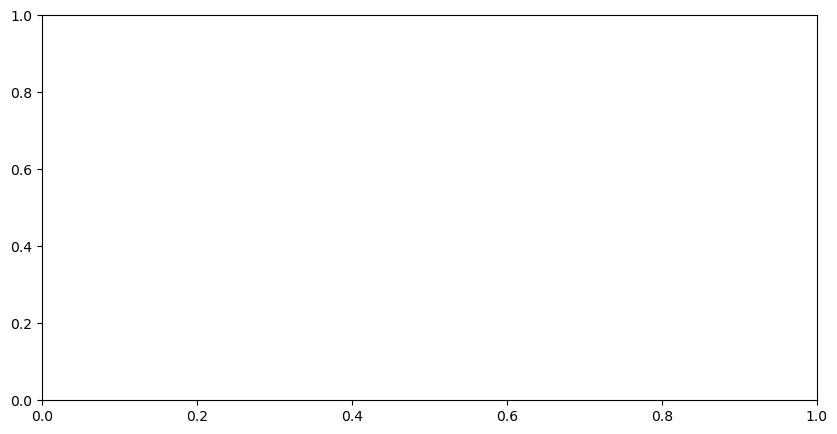

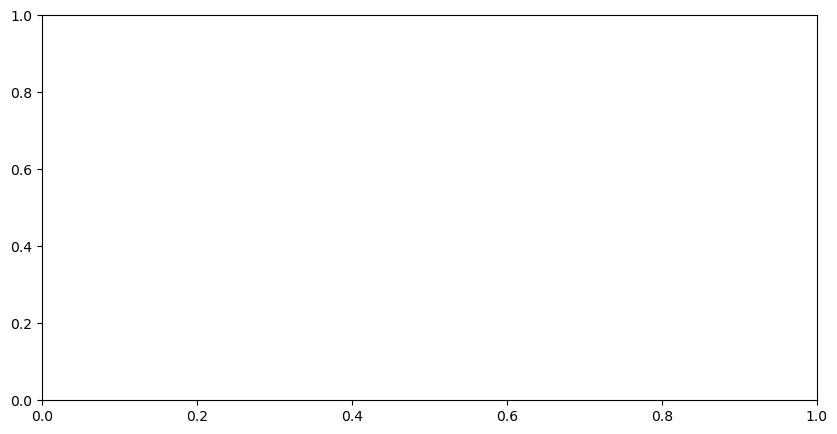

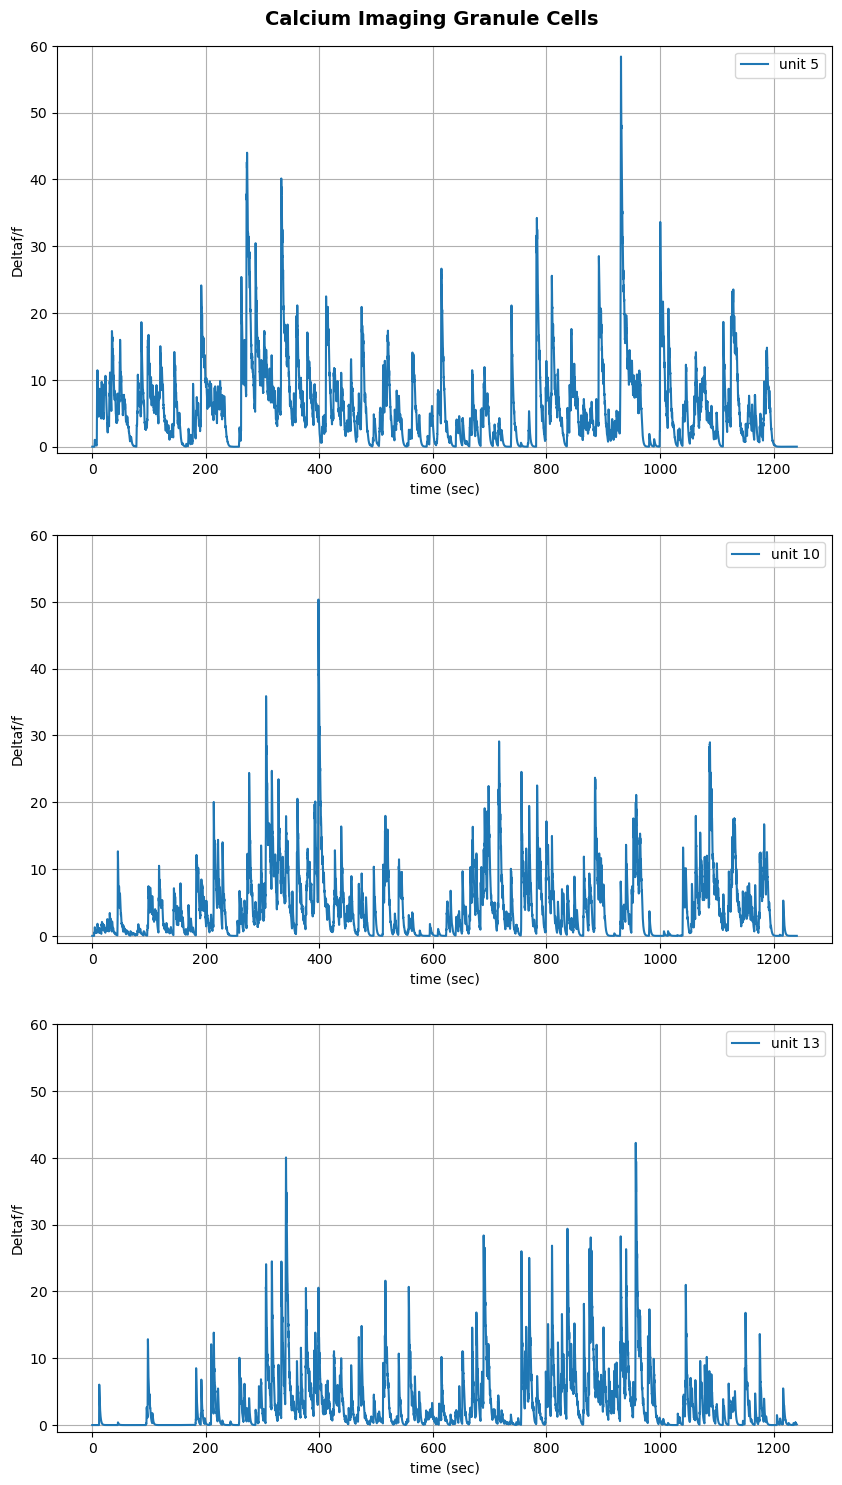

In [22]:
# check your data - plot some channels
units = [5,10,13]
fig, axs = plt.subplots(len(units),1, figsize=(10,18))

for u in range(len(units)):
    axs[u].plot(time_array,channels_array[:,units[u]], label='unit %d'%units[u])
    axs[u].set_xlabel('time (sec)')
    axs[u].set_ylabel('Deltaf/f')
    #axs[u].set_ylim([-0.001,0.01])
    axs[u].set_ylim([-1,60])
    axs[u].grid()
    axs[u].legend()
    
fig.suptitle('Calcium Imaging Granule Cells', y=0.9, fontsize=14, fontweight='bold')
plt.show()

# Load behavioural data

In [23]:
# load the behavioral data
#folder_name = "trial_info"
#bhv_info_filename = "trial_info_2021-05-{0}.mat".format(session)
#trial_info = scipy.io.loadmat(os.path.join(animal_folder_name,folder_name, bhv_info_filename))

# extract information from trial_info: in matlab this is a struct with the fields:
#trials_start_time = trial_info['trial_info'][0,0][0].ravel()
#trials_stimulus_on = trial_info['trial_info'][0,0][1].ravel()
#trials_response = trial_info['trial_info'][0,0][2].ravel()
#trials_is_right_lick = trial_info['trial_info'][0,0][3].ravel()
#trials_is_reward = trial_info['trial_info'][0,0][4].ravel()
#trials_end_time = trial_info['trial_info'][0,0][5].ravel()
#n_trials = len(trials_end_time)

# load behavioural data (.pkl file)
input_filename = "trial_info/trial_info_2021-05-{0}.pkl".format(session)
with open(os.path.join(animal_folder_name,input_filename), 'rb') as fp:
     trial_info = pickle.load(fp)

# extract information for trial_info: in PYTHON
trials_start_time = np.array(trial_info['start_time'])
trials_stimulus_on = np.array(trial_info['stimulus_on'])
trials_response = np.array(trial_info['response'])
trials_is_right_lick = np.array(trial_info['is_right_lick'])
trials_is_reward = np.array(trial_info['is_reward'])
trials_end_time = np.array(trial_info['end_trial'])
n_trials = len(trials_end_time)

# 500msec between start and stimulus onset
new_start = [] # initiate empty list
new_end = [] # initiate empty list
new_start.append(trials_stimulus_on[0]-0.5) # append first start
new_end.append(trials_stimulus_on[1]-0.5) # append first end
for i in range(1,n_trials-1): # append start & end times for each trial (except last)
    new_start.append(trials_stimulus_on[i]-0.5)
    new_end.append(trials_stimulus_on[i+1]-0.5)
new_start.append(trials_stimulus_on[n_trials-1]-0.5) # append last start
new_end.append(trials_end_time[n_trials-1]) # append last end
new_start = np.array(new_start) # turn list to array
new_end = np.array(new_end)
n_trials = len(new_end)

# alternatively, check where the stimulus was and try to decode that from the trials aligned at stimulus onset
# where was the stimulus? we don't have this info. But it can be reconstructed 
stimulus_reconstruction = np.zeros(shape=(n_trials,))
right_choice = np.where(trials_is_reward==1)[0]
stimulus_reconstruction[right_choice] = trials_is_right_lick[right_choice]
wrong_choice = np.where(trials_is_reward==0)[0]
stimulus_reconstruction[wrong_choice] = 1 - trials_is_right_lick[wrong_choice]

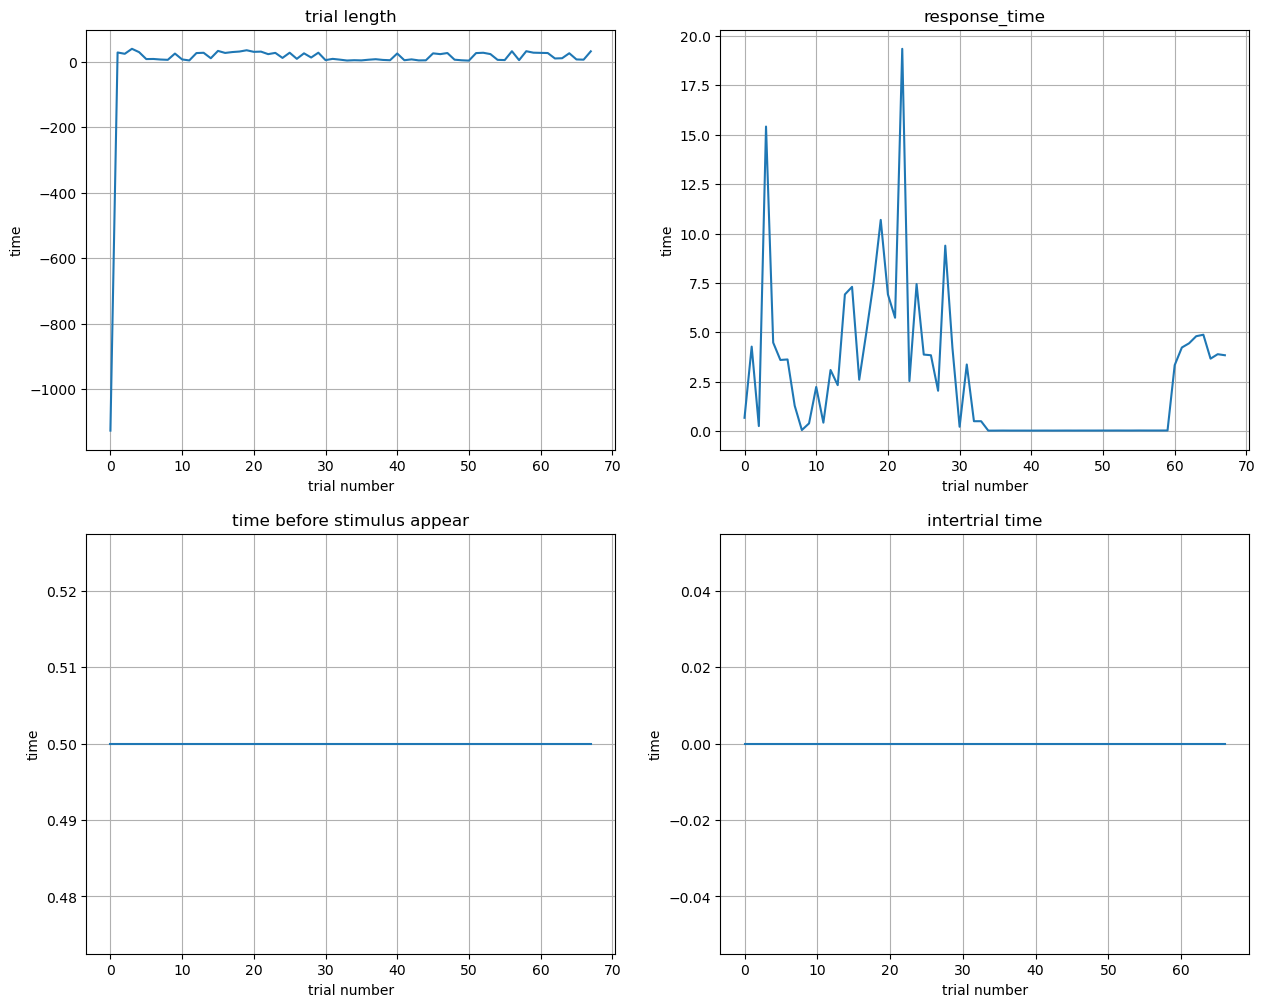

In [24]:
# trial length, response time, time before stimulus appears and intertrial time
fig, axs = plt.subplots(2,2,figsize=(15,12))
trials_length = new_end - new_start
response_time = trials_response - trials_stimulus_on
stim_time = trials_stimulus_on - new_start
intertrial_time = []
for i in range(1,n_trials):
    intertrial_time.append(new_start[i] - new_end[i-1])

# plot variables in subplots
axs[0, 0].plot(np.arange(n_trials), trials_length)
axs[0, 0].set_title('trial length')
axs[0, 1].plot(np.arange(n_trials), response_time)
axs[0, 1].set_title('response_time')
axs[1, 0].plot(np.arange(n_trials), stim_time)
axs[1, 0].set_title('time before stimulus appear')
axs[1, 1].plot(np.arange(n_trials-1), intertrial_time)
axs[1, 1].set_title('intertrial time')

# label axes
for ax in axs.flat:
    ax.set(xlabel='trial number', ylabel='time')
    ax.grid()
    
plt.show()

In [25]:
# split traces data into trials
X = {}
for i in range(n_trials):
    lower_bound = np.min(np.where(time_array>=new_start[i]))
    upper_bound = np.max(np.where(time_array<=new_end[i]))
    X[i] = channels_array[lower_bound:upper_bound,:]

# Bar plots of neuron activity (mean + var)

In [42]:
####### START OF TRIAL
start_timepoint = 0
n_after_start = 7 # 700msec
start_window = {}

selected_trials = ((trials_response - new_start)/sampling_rate > n_after_start)
n_trials_ = np.sum(selected_trials)

for i in range(n_trials_):
    if selected_trials[i]==1:
        start_window[i] = X[i][start_timepoint:n_after_start]

# bar plot using only mean
fig = plt.subplots(figsize =(10, 5))
 
# set height of bar
mean_activity = np.array([start_window[i] for i in start_window]).mean(axis=0)
mean_activity = np.mean(mean_activity, axis=0)

# Make the plot
plt.bar(np.arange(len(mean_activity)), mean_activity, color ='r', width = 0.7,
        edgecolor ='grey', label ='mean')
 
# Adding Xticks
plt.xlabel('Neurons', fontweight ='bold', fontsize = 15)
plt.ylabel('Activity', fontweight ='bold', fontsize = 15)
plt.ylim(0,20)
plt.legend()
plt.show()

# bar plot using only variance
fig = plt.subplots(figsize =(10, 5))
 
# set height of bar
var_activity = np.array([start_window[i] for i in start_window]).var(axis=0)
var_activity = np.var(var_activity, axis=0)

# Make the plot
plt.bar(np.arange(len(var_activity)), var_activity, color ='g', width = 0.7,
        edgecolor ='grey', label ='variance')
 
# Adding Xticks
plt.xlabel('Neurons', fontweight ='bold', fontsize = 15)
plt.ylabel('Activity', fontweight ='bold', fontsize = 15)
plt.ylim(0,7000)
plt.legend()
plt.show()

<ipython-input-42-c47f8cd367da>:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  mean_activity = np.array([start_window[i] for i in start_window]).mean(axis=0)


ValueError: operands could not be broadcast together with shapes (0,27) (7,27) 

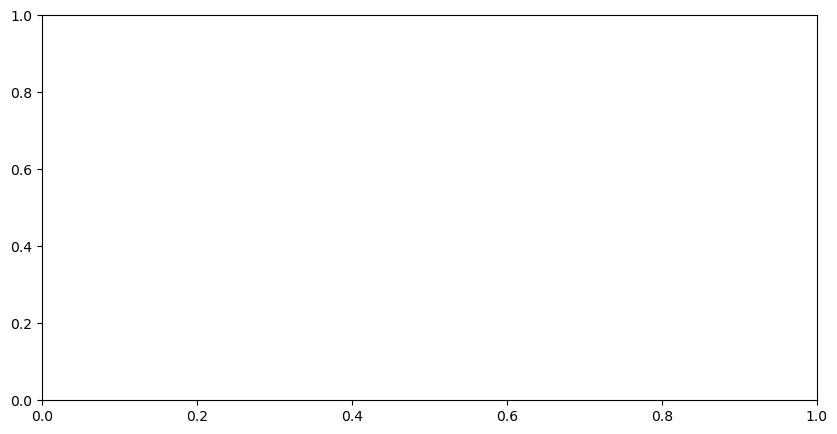

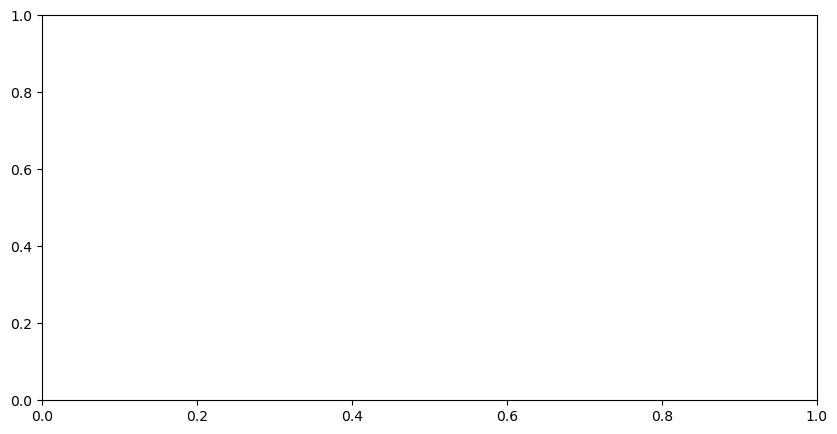

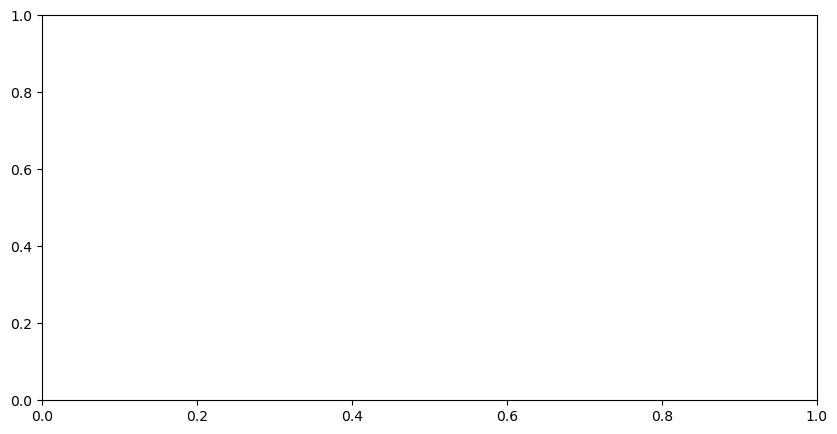

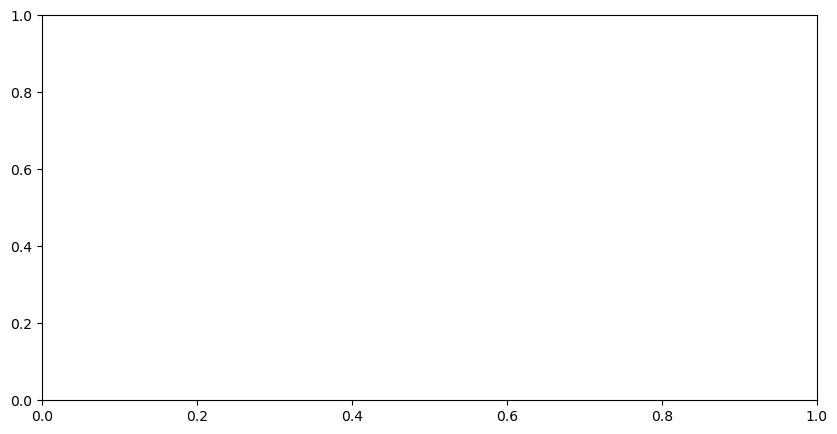

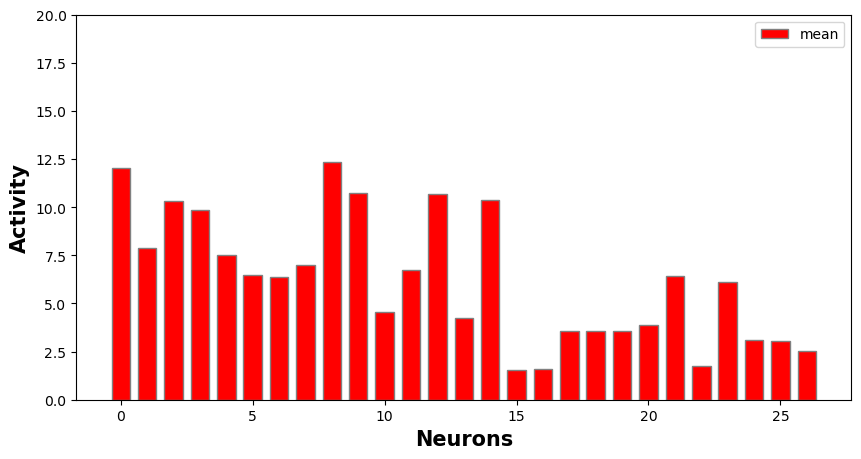

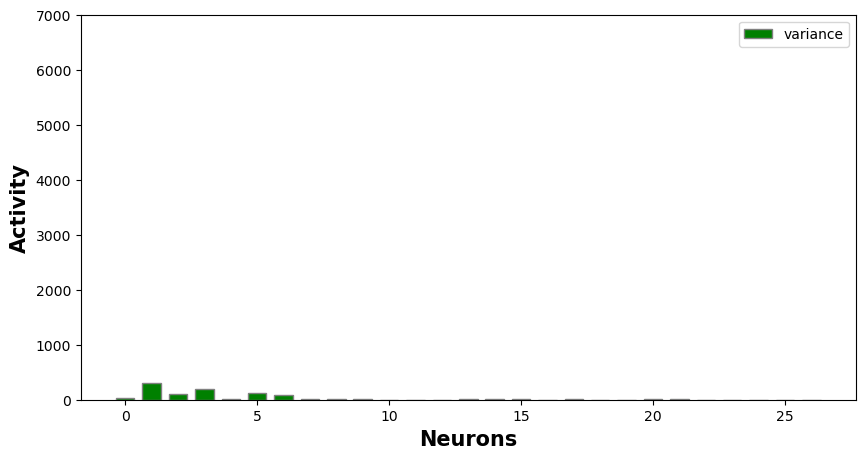

In [43]:
####### STIMULUS ONSET
n_before_stim = 2 # 200msec before
n_after_stim = 5 # 500msec after
stim_onset_window = {}

for i in range(n_trials):
    # timepoints for stimulus onset and end of trial
    stim_timepoint = int((trials_stimulus_on[i] - new_start[i]) /sampling_rate)
    stim_onset_window[i] = X[i][stim_timepoint-n_before_stim:stim_timepoint + n_after_stim]

# only trials with time window of 7
stim_onset_window_corr = {}
for i in range(n_trials):
    if len(stim_onset_window[i])>6:
        stim_onset_window_corr[i] = stim_onset_window[i]
    
# bar plot using only mean
fig = plt.subplots(figsize =(10, 5))
 
# set height of bar
mean_activity = np.array([stim_onset_window_corr[i] for i in stim_onset_window_corr]).mean(axis=0)
mean_activity = np.mean(mean_activity, axis=0)

# Make the plot
plt.bar(np.arange(len(mean_activity)), mean_activity, color ='r', width = 0.7,
        edgecolor ='grey', label ='mean')
 
# Adding Xticks
plt.xlabel('Neurons', fontweight ='bold', fontsize = 15)
plt.ylabel('Activity', fontweight ='bold', fontsize = 15)
plt.ylim(0,20)
plt.legend()
plt.show()

# bar plot using only variance
fig = plt.subplots(figsize =(10, 5))
 
# set height of bar
var_activity = np.array([stim_onset_window_corr[i] for i in stim_onset_window_corr]).var(axis=0)
var_activity = np.var(var_activity, axis=0)

# Make the plot
plt.bar(np.arange(len(var_activity)), var_activity, color ='g', width = 0.7,
        edgecolor ='grey', label ='variance')
 
# Adding Xticks
plt.xlabel('Neurons', fontweight ='bold', fontsize = 15)
plt.ylabel('Activity', fontweight ='bold', fontsize = 15)
plt.ylim(0,7000)
plt.legend()
plt.show()

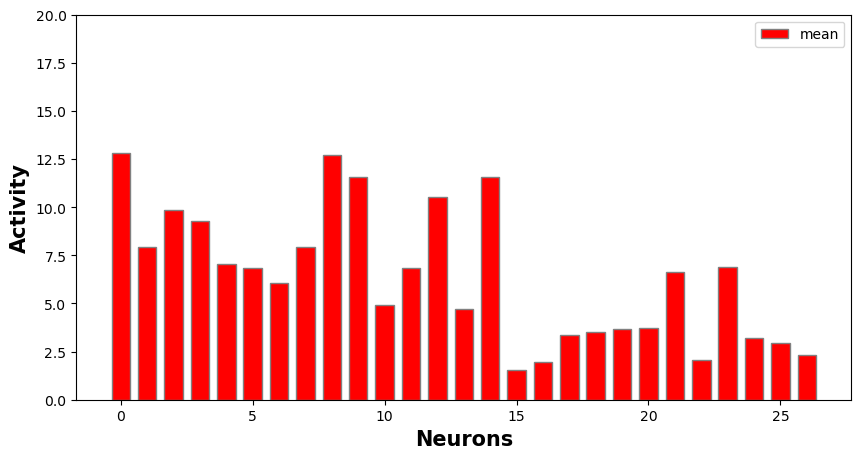

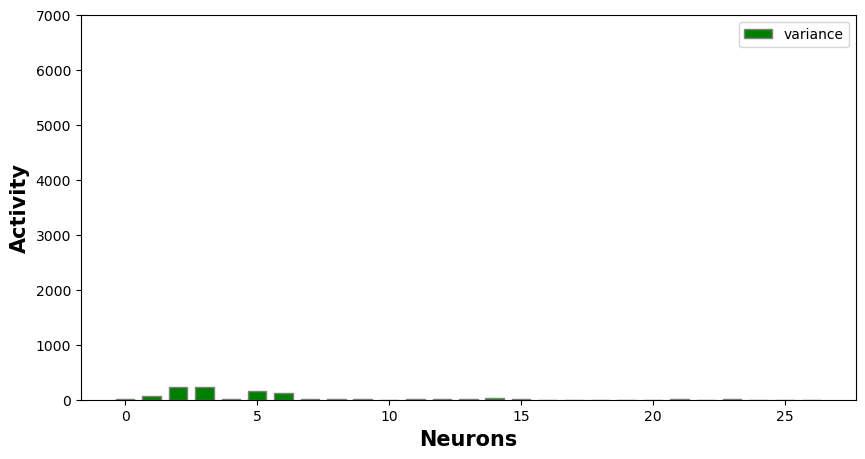

In [44]:
####### RESPONSE
n_before_resp = 5 # 500msec before
n_after_resp = 2 # 200msec after
resp_window = {}


for i in range(n_trials):
    # timepoints for response and end of trial
    resp_timepoint = int((trials_response[i] - new_start[i]) / sampling_rate)    
    resp_window[i] = X[i][resp_timepoint - n_before_resp:resp_timepoint+n_after_resp]

# only trials with time window of 7
resp_window_corr = {}
for i in range(n_trials):
    if len(resp_window[i])>6:
        resp_window_corr[i] = resp_window[i]
    
# bar plot using only mean
fig = plt.subplots(figsize =(10, 5))
 
# set height of bar
mean_activity = np.array([resp_window_corr[i] for i in resp_window_corr]).mean(axis=0)
mean_activity = np.mean(mean_activity, axis=0)

# Make the plot
plt.bar(np.arange(len(mean_activity)), mean_activity, color ='r', width = 0.7,
        edgecolor ='grey', label ='mean')
 
# Adding Xticks
plt.xlabel('Neurons', fontweight ='bold', fontsize = 15)
plt.ylabel('Activity', fontweight ='bold', fontsize = 15)
plt.ylim(0,20)
plt.legend()
plt.show()

# bar plot using only variance
fig = plt.subplots(figsize =(10, 5))
 
# set height of bar
var_activity = np.array([resp_window_corr[i] for i in resp_window_corr]).var(axis=0)
var_activity = np.var(var_activity, axis=0)

# Make the plot
plt.bar(np.arange(len(var_activity)), var_activity, color ='g', width = 0.7,
        edgecolor ='grey', label ='variance')
 
# Adding Xticks
plt.xlabel('Neurons', fontweight ='bold', fontsize = 15)
plt.ylabel('Activity', fontweight ='bold', fontsize = 15)
plt.ylim(0,7000)
plt.legend()
plt.show()

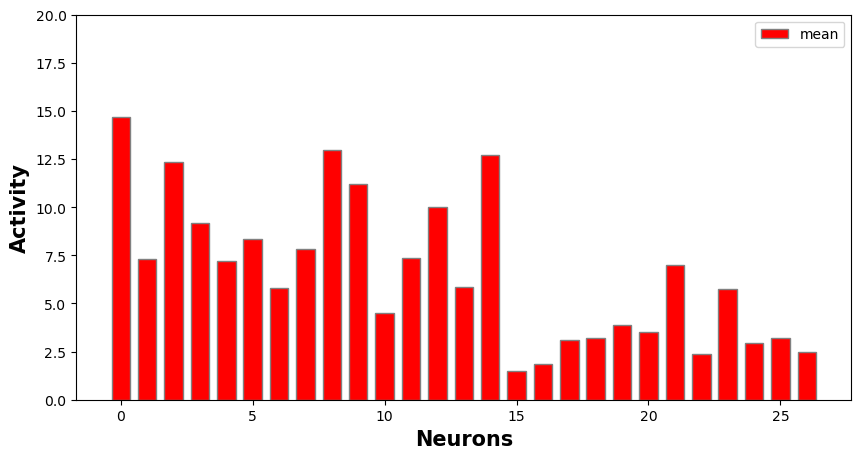

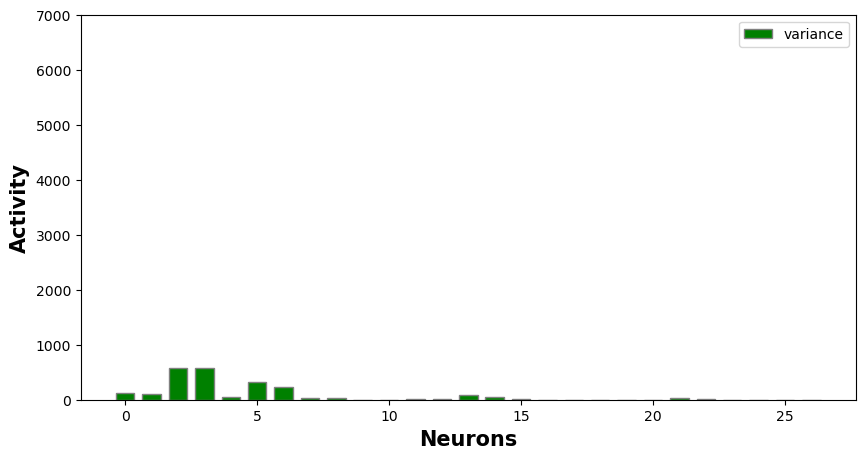

In [45]:
####### PUNISHMENT
n_before_pun = 2 # 200msec before
n_after_pun = 5 # 500msec after
punish_window = {}

j=0
for i in range(n_trials):
    # only punishment trials
    if trials_is_reward[i]==0:
        # timepoints for response and end of trial
        resp_timepoint = int((trials_response[i] - new_start[i]) / sampling_rate)
        punish_window[j] = X[i][resp_timepoint-n_before_pun:resp_timepoint+n_after_pun]
        j+=1

# only trials with time window of 7
punish_window_corr = {}
for i in range(len(punish_window)):
    if len(punish_window[i])>6:
        punish_window_corr[i] = punish_window[i]
    
# bar plot using only mean
fig = plt.subplots(figsize =(10, 5))
 
# set height of bar
mean_activity = np.array([punish_window_corr[i] for i in punish_window_corr]).mean(axis=0)
mean_activity = np.mean(mean_activity, axis=0)

# Make the plot
plt.bar(np.arange(len(mean_activity)), mean_activity, color ='r', width = 0.7,
        edgecolor ='grey', label ='mean')
 
# Adding Xticks
plt.xlabel('Neurons', fontweight ='bold', fontsize = 15)
plt.ylabel('Activity', fontweight ='bold', fontsize = 15)
plt.ylim(0,20)
plt.legend()
plt.show()

# bar plot using only variance
fig = plt.subplots(figsize =(10, 5))
 
# set height of bar
var_activity = np.array([punish_window_corr[i] for i in punish_window_corr]).var(axis=0)
var_activity = np.var(var_activity, axis=0)

# Make the plot
plt.bar(np.arange(len(var_activity)), var_activity, color ='g', width = 0.7,
        edgecolor ='grey', label ='variance')
 
# Adding Xticks
plt.xlabel('Neurons', fontweight ='bold', fontsize = 15)
plt.ylabel('Activity', fontweight ='bold', fontsize = 15)
plt.ylim(0,7000)
plt.legend()
plt.show()

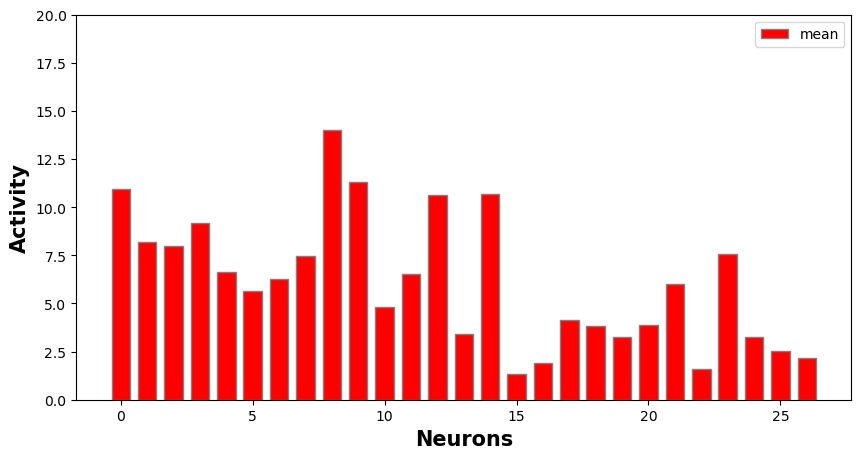

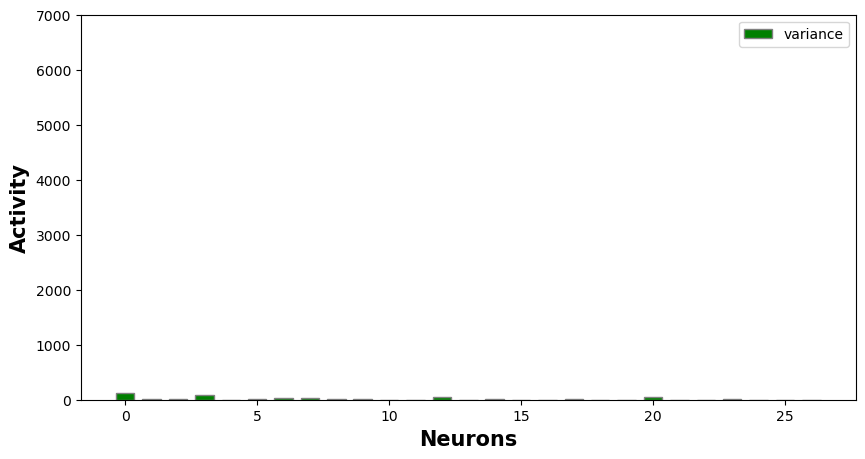

In [46]:
####### REWARD
n_before_rew = 2 # 200msec before
n_after_rew = 5 # 500msec after
rew_window = {}

j=0
for i in range(n_trials):
    # only reward trials
    if trials_is_reward[i]==1:
        # timepoints for response and end of trial
        resp_timepoint = int((trials_response[i] - new_start[i]) / sampling_rate)
        rew_window[j] = X[i][resp_timepoint-n_before_rew:resp_timepoint+n_after_rew]
        j+=1

# only trials with time window of 7
rew_window_corr = {}
for i in range(len(rew_window)):
    if len(rew_window[i])>6:
        rew_window_corr[i] = rew_window[i]
    
# bar plot using only mean
fig = plt.subplots(figsize =(10, 5))
 
# set height of bar
mean_activity = np.array([rew_window_corr[i] for i in rew_window_corr]).mean(axis=0)
mean_activity = np.mean(mean_activity, axis=0)

# Make the plot
plt.bar(np.arange(len(mean_activity)), mean_activity, color ='r', width = 0.7,
        edgecolor ='grey', label ='mean')
 
# Adding Xticks
plt.xlabel('Neurons', fontweight ='bold', fontsize = 15)
plt.ylabel('Activity', fontweight ='bold', fontsize = 15)
plt.ylim(0,20)
plt.legend()
plt.show()

# bar plot using only variance
fig = plt.subplots(figsize =(10, 5))
 
# set height of bar
var_activity = np.array([rew_window_corr[i] for i in rew_window_corr]).var(axis=0)
var_activity = np.var(var_activity, axis=0)

# Make the plot
plt.bar(np.arange(len(var_activity)), var_activity, color ='g', width = 0.7,
        edgecolor ='grey', label ='variance')
 
# Adding Xticks
plt.xlabel('Neurons', fontweight ='bold', fontsize = 15)
plt.ylabel('Activity', fontweight ='bold', fontsize = 15)
plt.ylim(0,7000)
plt.legend()
plt.show()

# pairwise correlations using all trials

<ipython-input-49-130c6ed01bcf>:8: RuntimeWarning: Degrees of freedom <= 0 for slice
  cov_trial = np.cov(X[i][start_timepoint:n_after_start], rowvar=False)


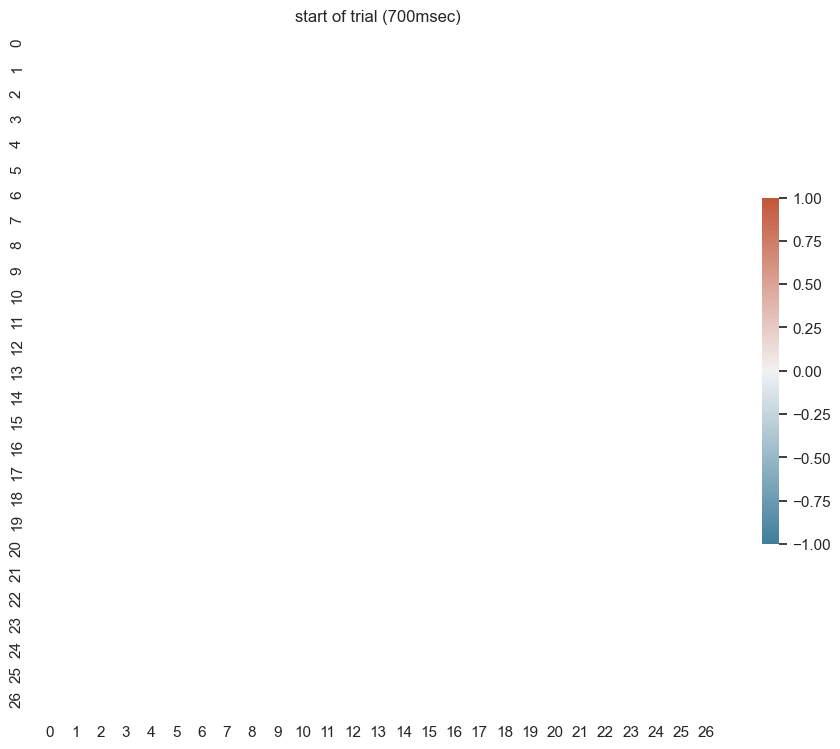

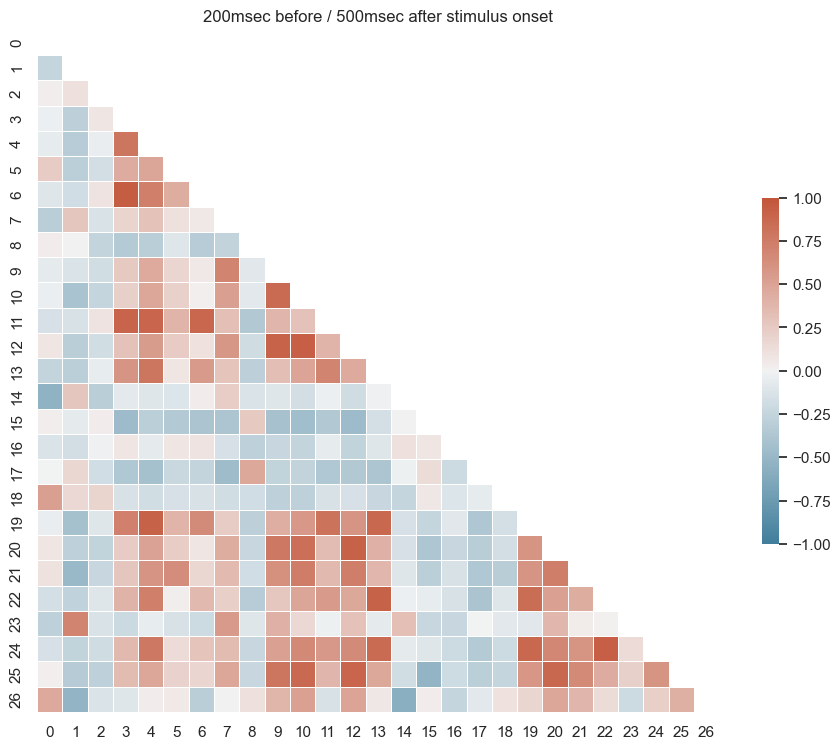

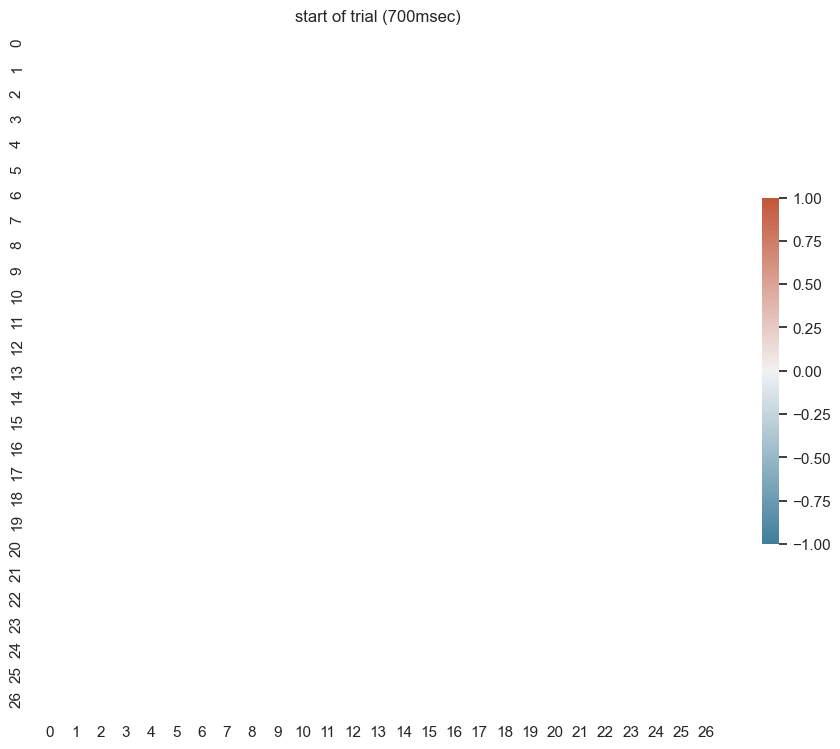

In [49]:
# start of trial
cov_trials = []
start_timepoint = 0
n_after_start = 7 # 700msec

for i in range(n_trials):
    # covariance matrix using start timepoint and end of time window tp
    cov_trial = np.cov(X[i][start_timepoint:n_after_start], rowvar=False)
    # append covariance matrices to list of trials
    cov_trials.append(cov_trial)
# mean covariance between channels across trials
cov = np.mean(np.array(cov_trials), axis=0)

# plot correlation matrix of channels: start
sns.set_theme(style="white")
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(pd.DataFrame(cov).corr(), dtype=bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(pd.DataFrame(cov).corr(), mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, vmin=-1, vmax=1)
ax.set_title('start of trial (700msec)')
plt.show()

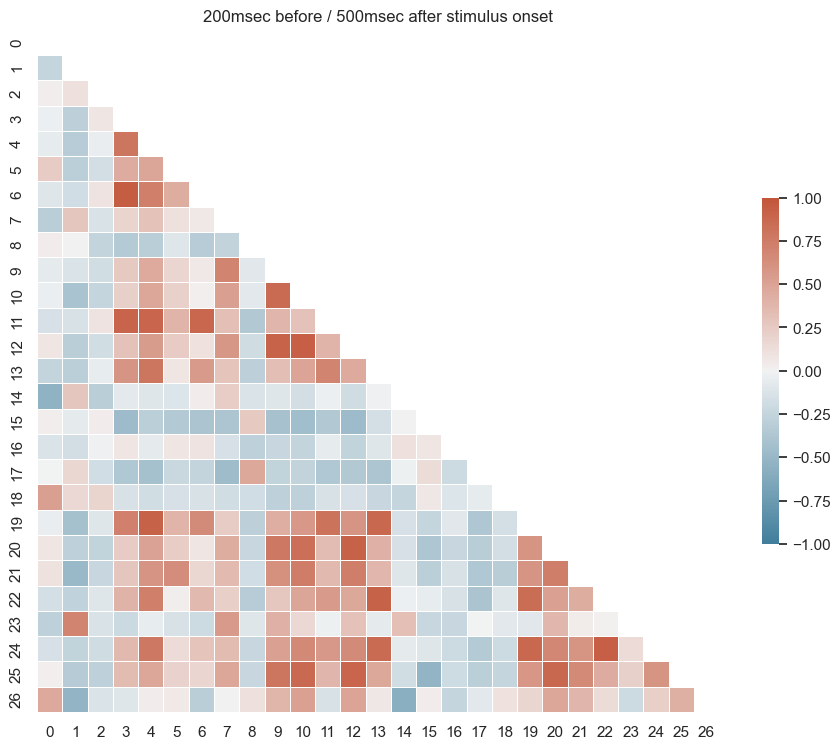

In [50]:
# 200msec before / 500msec after stimulus
cov_trials = []
n_before_stim = 2 # 200msec before
n_after_stim = 5 # 500msec after
time_window = n_before_stim+n_after_stim

selected_trials = ((new_end - trials_stimulus_on)/sampling_rate > time_window)
n_trials_ = np.sum(selected_trials)

for i in range(n_trials):
    if selected_trials[i]==1:
        # timepoint for stimulus
        stim_timepoint = int((trials_stimulus_on[i] - new_start[i]) /sampling_rate)
        # covariance matrix
        cov_trial = np.cov(X[i][stim_timepoint-n_before_stim:stim_timepoint + n_after_stim], rowvar=False)
        # append covariance matrices to list of trials
        cov_trials.append(cov_trial)
# mean covariance between channels across trials
cov = np.mean(np.array(cov_trials), axis=0)

# plot correlation matrix of channels: stimulus onset
sns.set_theme(style="white")
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(pd.DataFrame(cov).corr(), dtype=bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(pd.DataFrame(cov).corr(), mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, vmin=-1, vmax=1)
ax.set_title('200msec before / 500msec after stimulus onset')
plt.show()

<ipython-input-51-9b4bb3fe9ef5>:15: RuntimeWarning: Degrees of freedom <= 0 for slice
  cov_trial = np.cov(X[i][resp_timepoint - n_before_resp:resp_timepoint+n_after_resp], rowvar=False)


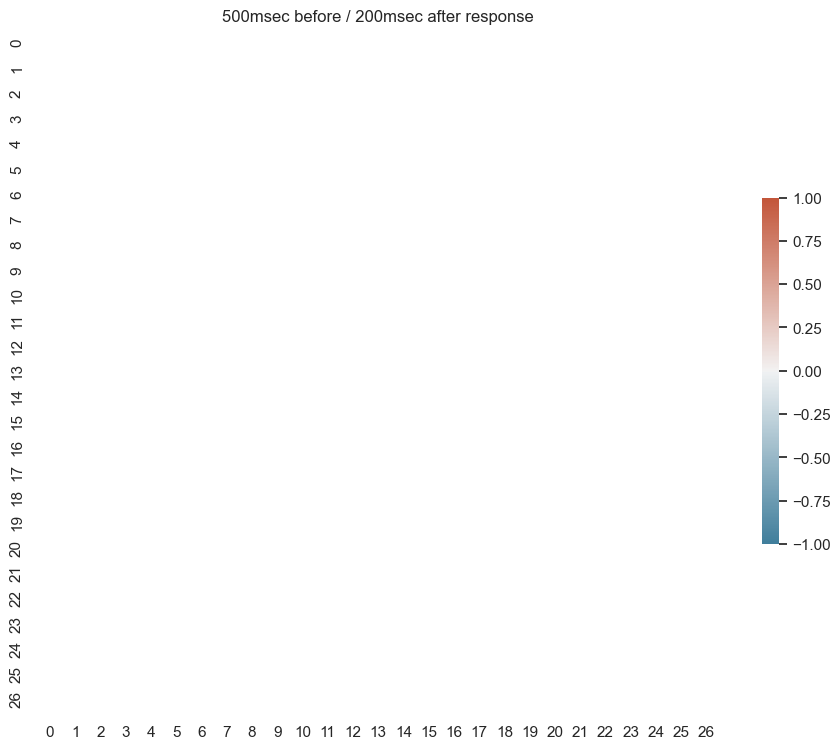

In [51]:
# 500msec before / 200msec after response
cov_trials = []
n_before_resp = 5 # 500msec before
n_after_resp = 2 # 200msec after
time_window = n_before_resp+n_after_resp

selected_trials = ((trials_response - new_start)/sampling_rate > time_window)
n_trials_ = np.sum(selected_trials)

for i in range(n_trials_):
    if selected_trials[i]==1:
        # timepoint for response
        resp_timepoint = int((trials_response[i] - new_start[i]) / sampling_rate)    
        # covariance matrix
        cov_trial = np.cov(X[i][resp_timepoint - n_before_resp:resp_timepoint+n_after_resp], rowvar=False)
        # append covariance matrices to list of trials
        cov_trials.append(cov_trial)
# mean covariance between channels across trials
cov = np.mean(np.array(cov_trials), axis=0)

# plot correlation matrix of channels: response
sns.set_theme(style="white")
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(pd.DataFrame(cov).corr(), dtype=bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(pd.DataFrame(cov).corr(), mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, vmin=-1, vmax=1)
ax.set_title('500msec before / 200msec after response')
plt.show()

# pairwise correlation using only punishment trials

<ipython-input-52-73e2583e3c6d>:10: RuntimeWarning: Degrees of freedom <= 0 for slice
  cov_trial = np.cov(X[i][start_timepoint:n_after_start], rowvar=False)


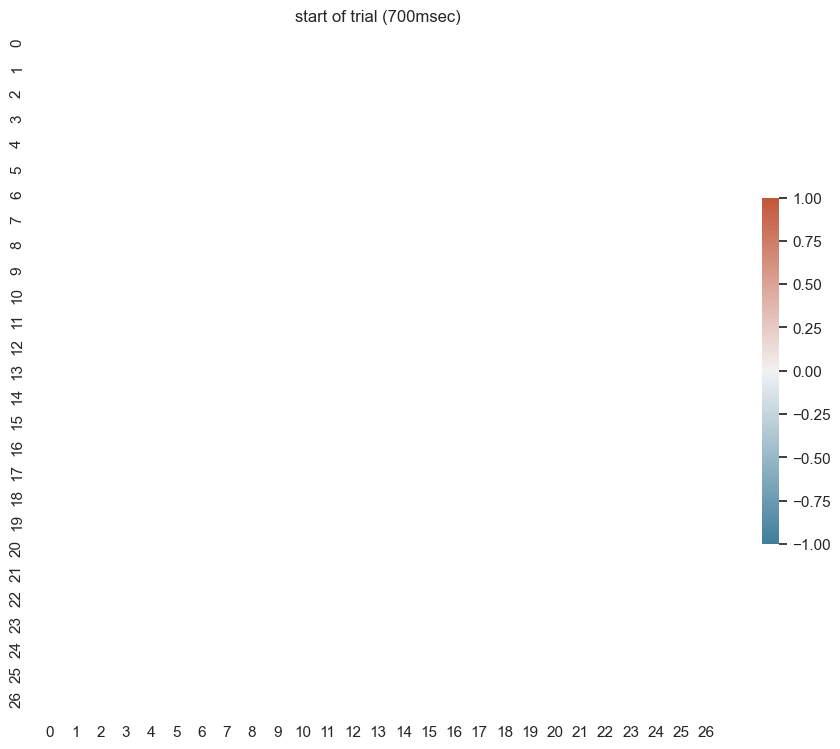

In [52]:
# 700msec at start of trial (punishment trials)
cov_trials = []
start_timepoint = 0
n_after_start = 7 # 700msec

for i in range(n_trials):
    # only punishment trials
    if trials_is_reward[i]==0:
        # covariance matrix using start timepoint
        cov_trial = np.cov(X[i][start_timepoint:n_after_start], rowvar=False)
        # append covariance matrices to list of trials
        cov_trials.append(cov_trial)
# mean covariance between channels across trials
cov = np.mean(np.array(cov_trials), axis=0)

# plot correlation matrix of channels: start
sns.set_theme(style="white")
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(pd.DataFrame(cov).corr(), dtype=bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(pd.DataFrame(cov).corr(), mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, vmin=-1, vmax=1)
ax.set_title('start of trial (700msec)')
plt.show()

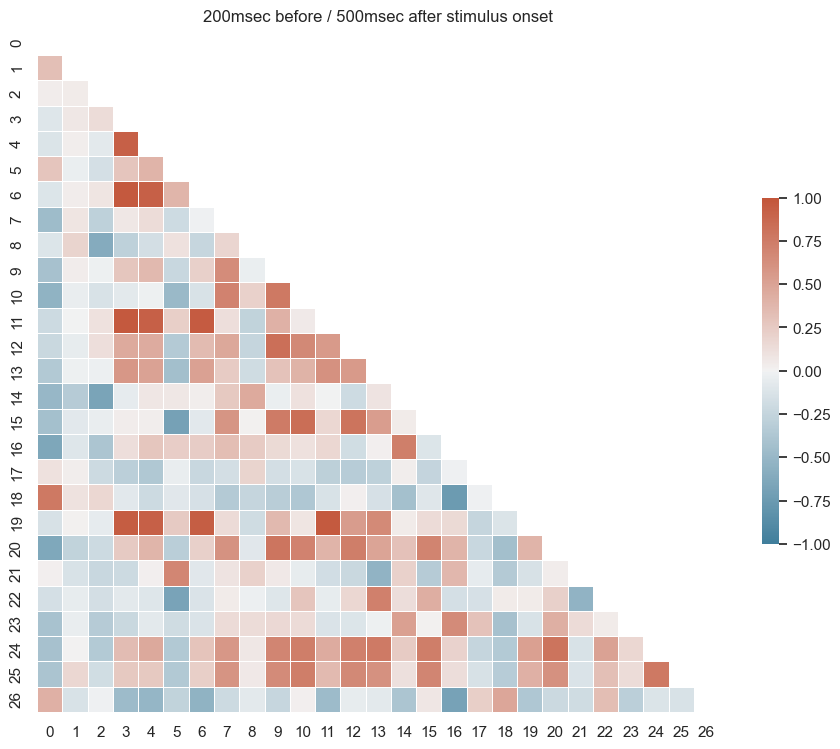

In [53]:
# 200msec before / 500msec after stimulus (punishment trials)
cov_trials = []
n_before_stim = 2 # 200msec before
n_after_stim = 5 # 500msec after
time_window = n_before_stim+n_after_stim

selected_trials = ((new_end - trials_stimulus_on)/sampling_rate > time_window)
n_trials_ = np.sum(selected_trials)

for i in range(n_trials):
    if selected_trials[i]==1:
        # only punishment trials
        if trials_is_reward[i]==0:
            # timepoint for stimulus
            stim_timepoint = int((trials_stimulus_on[i] - new_start[i]) /sampling_rate)
            # covariance matrix
            cov_trial = np.cov(X[i][stim_timepoint-n_before_stim:stim_timepoint + n_after_stim], rowvar=False)
            # append covariance matrices to list of trials
            cov_trials.append(cov_trial)
# mean covariance between channels across trials
cov = np.mean(np.array(cov_trials), axis=0)

# plot correlation matrix of channels: stimulus onset
sns.set_theme(style="white")
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(pd.DataFrame(cov).corr(), dtype=bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(pd.DataFrame(cov).corr(), mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, vmin=-1, vmax=1)
ax.set_title('200msec before / 500msec after stimulus onset')
plt.show()

<ipython-input-54-f1c24e94ea1f>:17: RuntimeWarning: Degrees of freedom <= 0 for slice
  cov_trial = np.cov(X[i][resp_timepoint - n_before_resp:resp_timepoint+n_after_resp], rowvar=False)


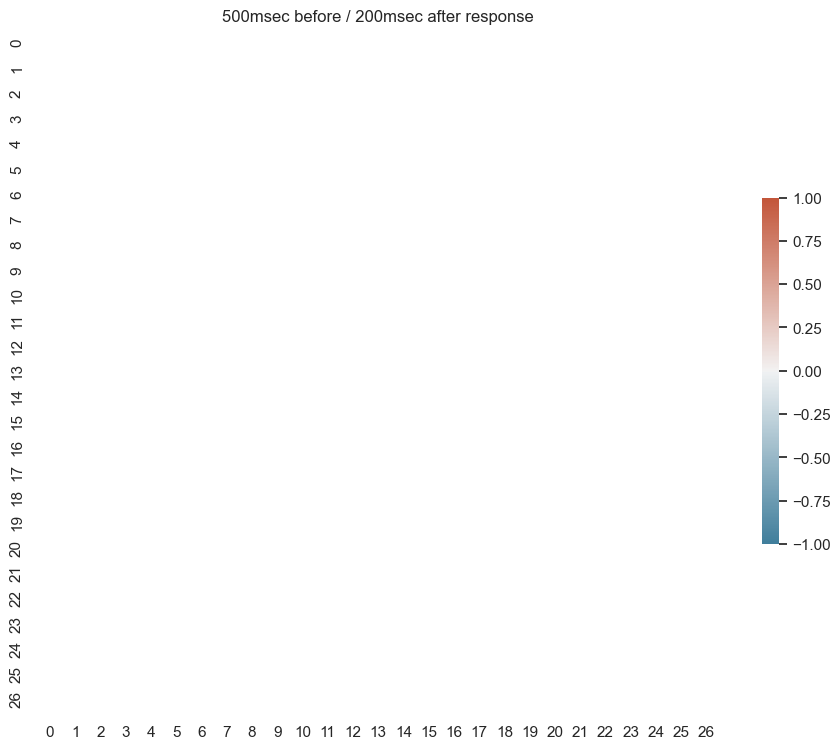

In [54]:
# 500msec before / 200msec after response (punishment trials)
cov_trials = []
n_before_resp = 5 # 500msec before
n_after_resp = 2 # 200msec after
time_window = n_before_resp+n_after_resp

selected_trials = ((trials_response - new_start)/sampling_rate > time_window)
n_trials_ = np.sum(selected_trials)

for i in range(n_trials_):
    if selected_trials[i]==1:
        # only punishment trials
        if trials_is_reward[i]==0:
            # timepoint for response
            resp_timepoint = int((trials_response[i] - new_start[i]) / sampling_rate)    
            # covariance matrix
            cov_trial = np.cov(X[i][resp_timepoint - n_before_resp:resp_timepoint+n_after_resp], rowvar=False)
            # append covariance matrices to list of trials
            cov_trials.append(cov_trial)
# mean covariance between channels across trials
cov = np.mean(np.array(cov_trials), axis=0)

# plot correlation matrix of channels: response
sns.set_theme(style="white")
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(pd.DataFrame(cov).corr(), dtype=bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(pd.DataFrame(cov).corr(), mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, vmin=-1, vmax=1)
ax.set_title('500msec before / 200msec after response')
plt.show()

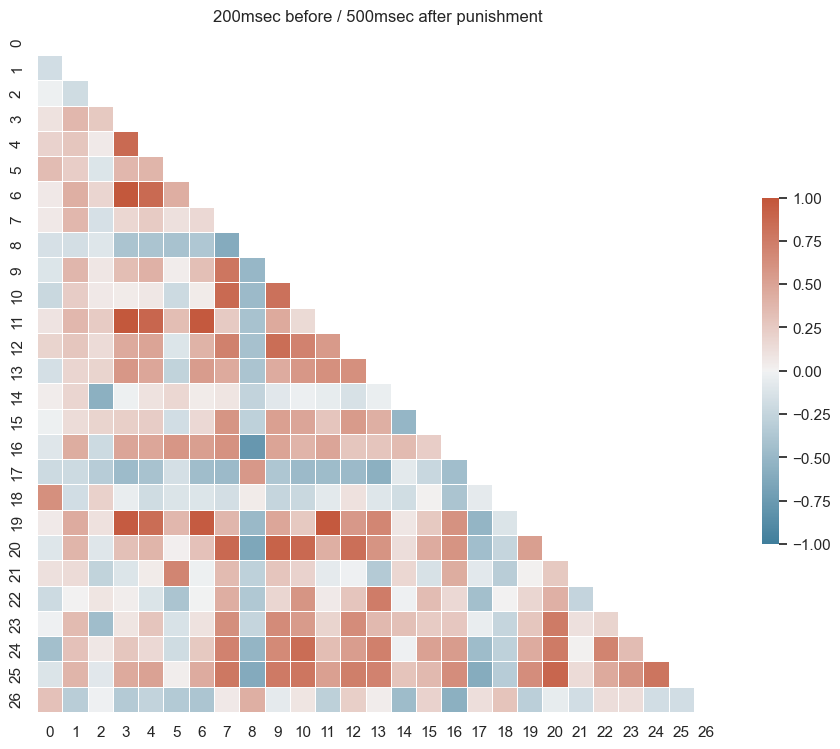

In [55]:
# 200msec before / 500msec after punishment
cov_trials = []
n_before_pun = 2 # 200msec before
n_after_pun = 5 # 500msec after
time_window = n_before_pun + n_after_pun

selected_trials = ((new_end - trials_response)/sampling_rate > time_window)
n_trials_ = np.sum(selected_trials)

for i in range(n_trials_):
    if selected_trials[i]==1:
        # only punishment trials
        if trials_is_reward[i]==0:
            # timepoints for response
            resp_timepoint = int((trials_response[i] - new_start[i]) / sampling_rate)
            # covariance matrix
            cov_trial = np.cov(X[i][resp_timepoint-n_before_pun:resp_timepoint+n_after_pun], rowvar=False)
            # append covariance matrices to list of trials
            cov_trials.append(cov_trial)
# mean covariance between channels across trials
cov = np.mean(np.array(cov_trials), axis=0)

# plot correlation matrix of channels: punishment
sns.set_theme(style="white")
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(pd.DataFrame(cov).corr(), dtype=bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(pd.DataFrame(cov).corr(), mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, vmin=-1, vmax=1)
ax.set_title('200msec before / 500msec after punishment')
plt.show()

# pairwise correlation using only reward trials

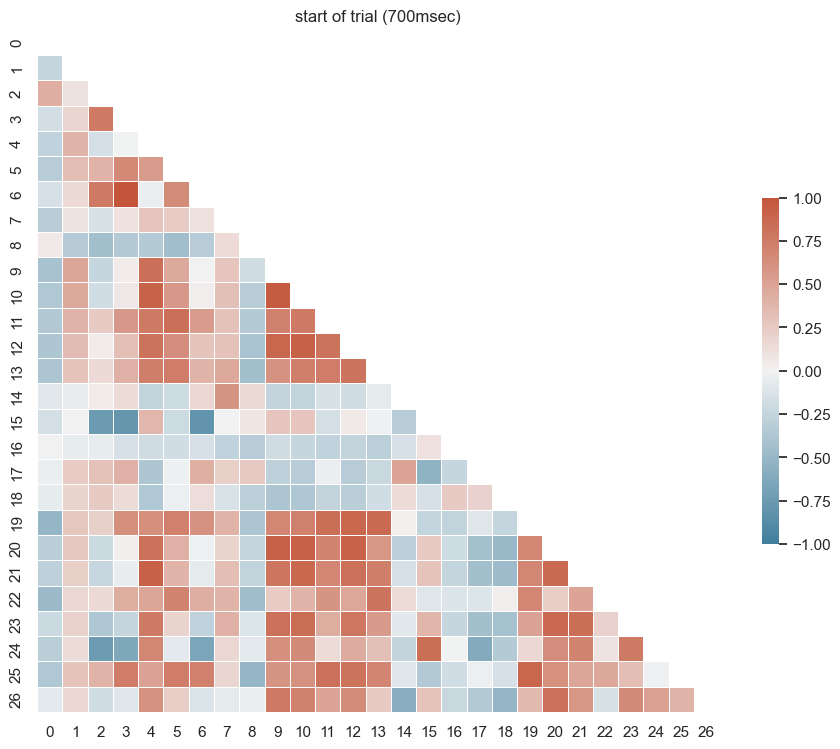

In [56]:
# 700msec at start of trial (reward trials)
cov_trials = []
start_timepoint = 0
n_after_start = 7 # 700msec

for i in range(n_trials):
    # only reward trials
    if trials_is_reward[i]==1:
        # covariance matrix using start timepoint
        cov_trial = np.cov(X[i][start_timepoint:n_after_start], rowvar=False)
        # append covariance matrices to list of trials
        cov_trials.append(cov_trial)
# mean covariance between channels across trials
cov = np.mean(np.array(cov_trials), axis=0)

# plot correlation matrix of channels: start
sns.set_theme(style="white")
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(pd.DataFrame(cov).corr(), dtype=bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(pd.DataFrame(cov).corr(), mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, vmin=-1, vmax=1)
ax.set_title('start of trial (700msec)')
plt.show()

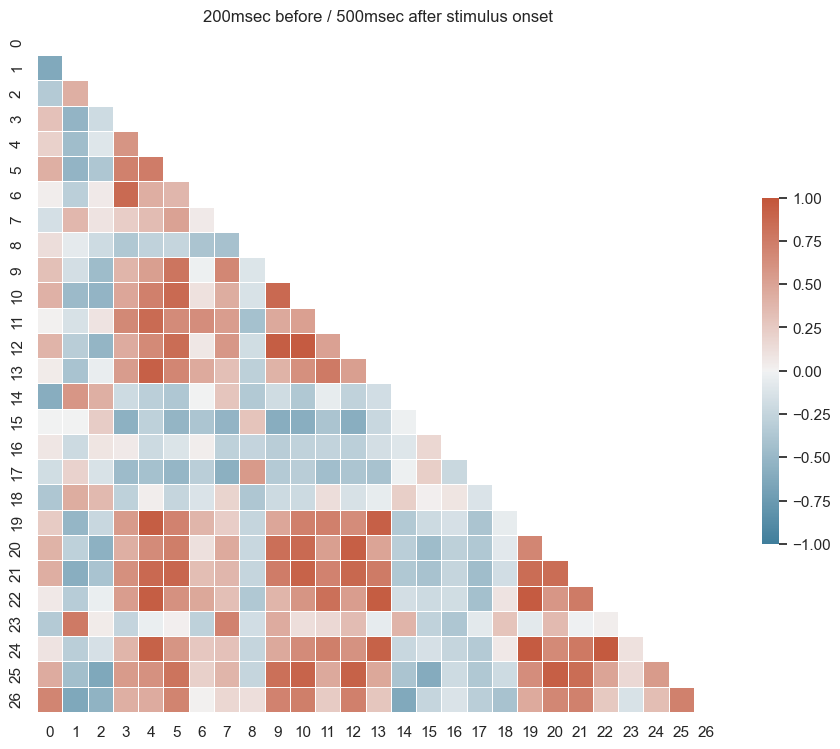

In [57]:
# 200msec before / 500msec after stimulus (reward trials)
cov_trials = []
n_before_stim = 2 # 200msec before
n_after_stim = 5 # 500msec after
time_window = n_before_stim+n_after_stim

selected_trials = ((new_end - trials_stimulus_on)/sampling_rate > time_window)
n_trials_ = np.sum(selected_trials)

for i in range(n_trials):
    if selected_trials[i]==1:
        # only reward trials
        if trials_is_reward[i]==1:
            # timepoint for stimulus
            stim_timepoint = int((trials_stimulus_on[i] - new_start[i]) /sampling_rate)
            # covariance matrix
            cov_trial = np.cov(X[i][stim_timepoint-n_before_stim:stim_timepoint + n_after_stim], rowvar=False)
            # append covariance matrices to list of trials
            cov_trials.append(cov_trial)
# mean covariance between channels across trials
cov = np.mean(np.array(cov_trials), axis=0)

# plot correlation matrix of channels: stimulus onset
sns.set_theme(style="white")
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(pd.DataFrame(cov).corr(), dtype=bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(pd.DataFrame(cov).corr(), mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, vmin=-1, vmax=1)
ax.set_title('200msec before / 500msec after stimulus onset')
plt.show()

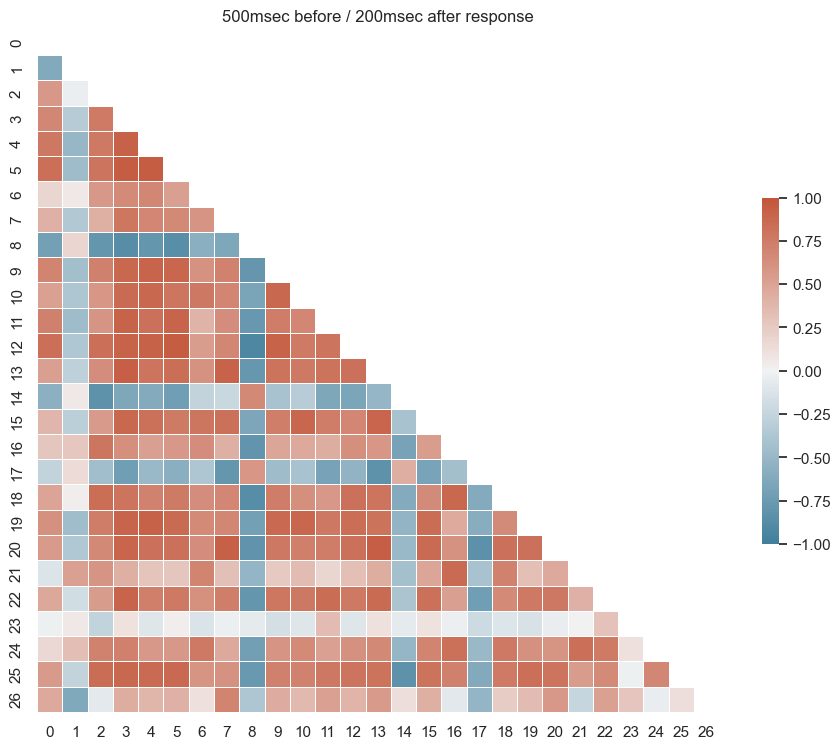

In [58]:
# 500msec before / 200msec after response (reward trials)
cov_trials = []
n_before_resp = 5 # 500msec before
n_after_resp = 2 # 200msec after
time_window = n_before_resp+n_after_resp

selected_trials = ((trials_response - new_start)/sampling_rate > time_window)
n_trials_ = np.sum(selected_trials)

for i in range(n_trials_):
    if selected_trials[i]==1:
        # only reward trials
        if trials_is_reward[i]==1:
            # timepoint for response
            resp_timepoint = int((trials_response[i] - new_start[i]) / sampling_rate)    
            # covariance matrix
            cov_trial = np.cov(X[i][resp_timepoint - n_before_resp:resp_timepoint+n_after_resp], rowvar=False)
            # append covariance matrices to list of trials
            cov_trials.append(cov_trial)
# mean covariance between channels across trials
cov = np.mean(np.array(cov_trials), axis=0)

# plot correlation matrix of channels: response
sns.set_theme(style="white")
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(pd.DataFrame(cov).corr(), dtype=bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(pd.DataFrame(cov).corr(), mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, vmin=-1, vmax=1)
ax.set_title('500msec before / 200msec after response')
plt.show()

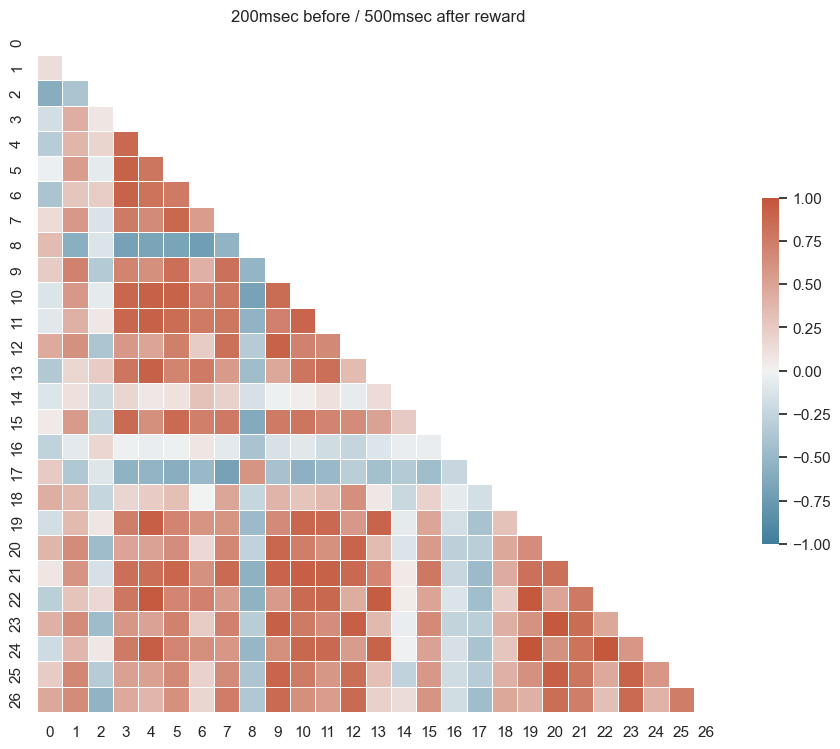

In [59]:
# 200msec before / 500msec after reward
cov_trials = []
n_before_rew = 2 # 200msec before
n_after_rew = 5 # 500msec after
time_window = n_before_rew+n_after_rew

selected_trials = ((new_end - trials_response)/sampling_rate > time_window)
n_trials_ = np.sum(selected_trials)

for i in range(n_trials_):
    if selected_trials[i]==1:
        # only reward trials
        if trials_is_reward[i]==1:
            # timepoints for response
            resp_timepoint = int((trials_response[i] - new_start[i]) / sampling_rate)
            # covariance matrix
            cov_trial = np.cov(X[i][resp_timepoint-n_before_rew:resp_timepoint+n_after_rew], rowvar=False)
            # append covariance matrices to list of trials
            cov_trials.append(cov_trial)
# mean covariance between channels across trials
cov = np.mean(np.array(cov_trials), axis=0)

# plot correlation matrix of channels: reward
sns.set_theme(style="white")
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(pd.DataFrame(cov).corr(), dtype=bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(pd.DataFrame(cov).corr(), mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, vmin=-1, vmax=1)
ax.set_title('200msec before / 500msec after reward')
plt.show()